## Automated anisotropic resistivity inversion for efficient formation evaluation and uncertainty quantification

### Misael M. Morales, Oriyomi Raheem, Ali Eghbali, Michael Pyrcz, Carlos Torres-Verdin, 2024
***

In [ ]:
from main import *
ari = ARI()
case1, case2 = ari.load_data()

### Case 1

In [ ]:
case1_qinv = ari.quadratic_inversion(case1)

In [ ]:
inv1 = ari.resistivity_inversion(case1, x0=[0.5,1.45], Rvsh=2.813, Rhsh=0.775, 
                                 Wd_matrix=True, tolerance=1e-10, maxiter=1e5, 
                                 lambda_reg=1e-8, method='CG', bounds=None)

ari.plot_inversion_results(inv1, figsize=(20,12))

In [ ]:
inv1 = ari.resistivity_inversion(case1, x0=[0.5, 1.45], Rvsh=2.813, Rhsh=0.775,
                                 Wd_matrix=True, tolerance=1e-10, maxiter=1e5,
                                 lambda_reg=1e-8, method='L-BFGS-B', bounds=[(0,1),(None,None)])

ari.plot_inversion_results(inv1, figsize=(20,12))

### Case 2

In [ ]:
case2_qinv = ari.quadratic_inversion(case2)

In [ ]:
inv2 = ari.resistivity_inversion(case2, x0=[0.5,1.45], Rvsh=4.043, Rhsh=0.674,
                                 Wd_matrix=True, tolerance=1e-10, maxiter=1e5, 
                                 lambda_reg=1e-8, method='CG', bounds=None)

ari.plot_inversion_results(inv2, figsize=(20,12))

In [ ]:
inv2 = ari.resistivity_inversion(case2, x0=[0.5,1.45], Rvsh=4.043, Rhsh=0.674, 
                                 Wd_matrix=True, tolerance=1e-8, maxiter=1e5, 
                                 lambda_reg=1e-8, method='L-BFGS-B', bounds=[(0,1),(None,None)])

ari.plot_inversion_results(inv2, figsize=(20,12))

***
# Physics-Informed Artificial Neural Network
***

In [ ]:
from main import *
ari = ARI()
case1, case2 = ari.load_data()

In [651]:
def plot_pinn_results(df, figsize=(15,10), subtitle:str=None):
    fig, axs = plt.subplots(1, 4, figsize=figsize, sharey=True)
    ax1, ax2, ax3, ax4 = axs

    ax11 = ax1.twiny()
    ari.plot_curve(ax1, df, 'GR', 0, 150, 'g', units='API', pad=8)
    ari.plot_curve(ax11, df, 'Csh_pred', 0, 1, 'k', units='v/v')

    ax21, ax22 = ax2.twiny(), ax2.twiny()
    ari.plot_curve(ax21, df, 'AT10', 0.02, 200, 'r', semilog=True, units='$\Omega\cdot m$', pad=8)
    ari.plot_curve(ax22, df, 'AT90', 0.02, 200, 'b', semilog=True, units='$\Omega\cdot m$', pad=16)
    ari.plot_curve(ax2, df, 'Rss_pred', 0.02, 200, 'k', units='$\Omega\cdot m$', semilog=True)

    ax31, ax32 = ax3.twiny(), ax3.twiny()
    ari.plot_curve(ax31, df, 'Rv', 0.02, 200, 'r', semilog=True, units='$\Omega\cdot m$', pad=8)
    ari.plot_curve(ax32, df, 'Rv_sim', 0.02, 200, 'k', units='$\Omega\cdot m$', semilog=True)
    ari.plot_curve(ax3, df, 'Rv_err', 0, 100, 'darkred', alpha=0.5, units='%', pad=16)

    ax41, ax42 = ax4.twiny(), ax4.twiny()
    ari.plot_curve(ax41, df, 'Rh', 0.02, 200, 'b', semilog=True, units='$\Omega\cdot m$', pad=8)
    ari.plot_curve(ax42, df, 'Rh_sim', 0.02, 200, 'k', units='$\Omega\cdot m$', semilog=True)
    ari.plot_curve(ax4, df, 'Rh_err', 0, 100, 'darkblue', alpha=0.5, units='%', pad=16)

    [ax.grid(True, which='both') for ax in axs]
    ax1.invert_yaxis()
    if subtitle is None:
        title = 'PINN Inversion Results'
    else:
        title = 'PINN Inversion Results | {}'.format(subtitle)
    fig.suptitle(title, weight='bold')
    plt.tight_layout()
    plt.show()

In [642]:
class PINNari(nn.Module):
    def __init__(self):
        super(PINNari, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2)
        
    def forward(self, x):
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = self.fc3(x)
        return x

In [653]:
class PhysicsInformedLoss(torch.nn.Module):
    def __init__(self, Rvsh=2.8133, Rhsh=0.7746):
        super(PhysicsInformedLoss, self).__init__()
        self.Rvsh = Rvsh
        self.Rhsh = Rhsh

    def forward(self, inputs, outputs):
        Rv_true, Rh_true = inputs[:, 0], inputs[:, 1]
        Csh, Rss = outputs[:, 0], outputs[:, 1]

        eq1 = (Csh*self.Rvsh + (1-Csh)*Rss) - Rv_true
        eq2 = (Csh/self.Rhsh + (1-Csh)/Rss) - (1/Rh_true)
        eqs = torch.cat((eq1, eq2), dim=0)

        return torch.norm(eqs, p=2)

In [654]:
d = lasio.read('well1.las').df()[['AT10','AT30','AT60','AT90','GR','RV72H_1D_FLT','RH72H_1D_FLT']].dropna()
#d = lasio.read('well2.LAS').df()[['AT10','AT30','AT60','AT90','HCGR','RV72_1DF','RH72_1DF']].dropna()

column_names = ['AT10', 'AT30', 'AT60', 'AT90', 'GR', 'Rv', 'Rh']
data = d.rename(columns=dict(zip(d.columns, column_names)))

res_aniso  = data[['Rv','Rh']]
Rvsh, Rhsh = 2.8133, 0.7746

In [655]:
inputs     = torch.tensor(res_aniso.values, dtype=torch.float32)
dataset    = TensorDataset(inputs)
dataloader = DataLoader(dataset, batch_size=200, shuffle=True)

model      = PINNari()
criterion  = PhysicsInformedLoss(Rvsh=Rvsh, Rhsh=Rhsh)
optimizer  = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 1000
for epoch in range(epochs):
    model.train()
    for batch in dataloader:
        optimizer.zero_grad()
        x = batch[0]
        y = model(x)
        loss = criterion(x, y)
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        print('Epoch: {} | Loss: {:.4f}'.format(epoch, loss))

Epoch: 0 | Loss: 97.8352
Epoch: 100 | Loss: 24.3534
Epoch: 200 | Loss: 14.9205
Epoch: 300 | Loss: 14.8728
Epoch: 400 | Loss: 14.4503
Epoch: 500 | Loss: 12.7881
Epoch: 600 | Loss: 12.9494
Epoch: 700 | Loss: 14.1963
Epoch: 800 | Loss: 14.0258
Epoch: 900 | Loss: 12.8297


/mnt/e/Anisotropic-Resistivity-Inversion/main.py:102: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xlim(lb, ub)


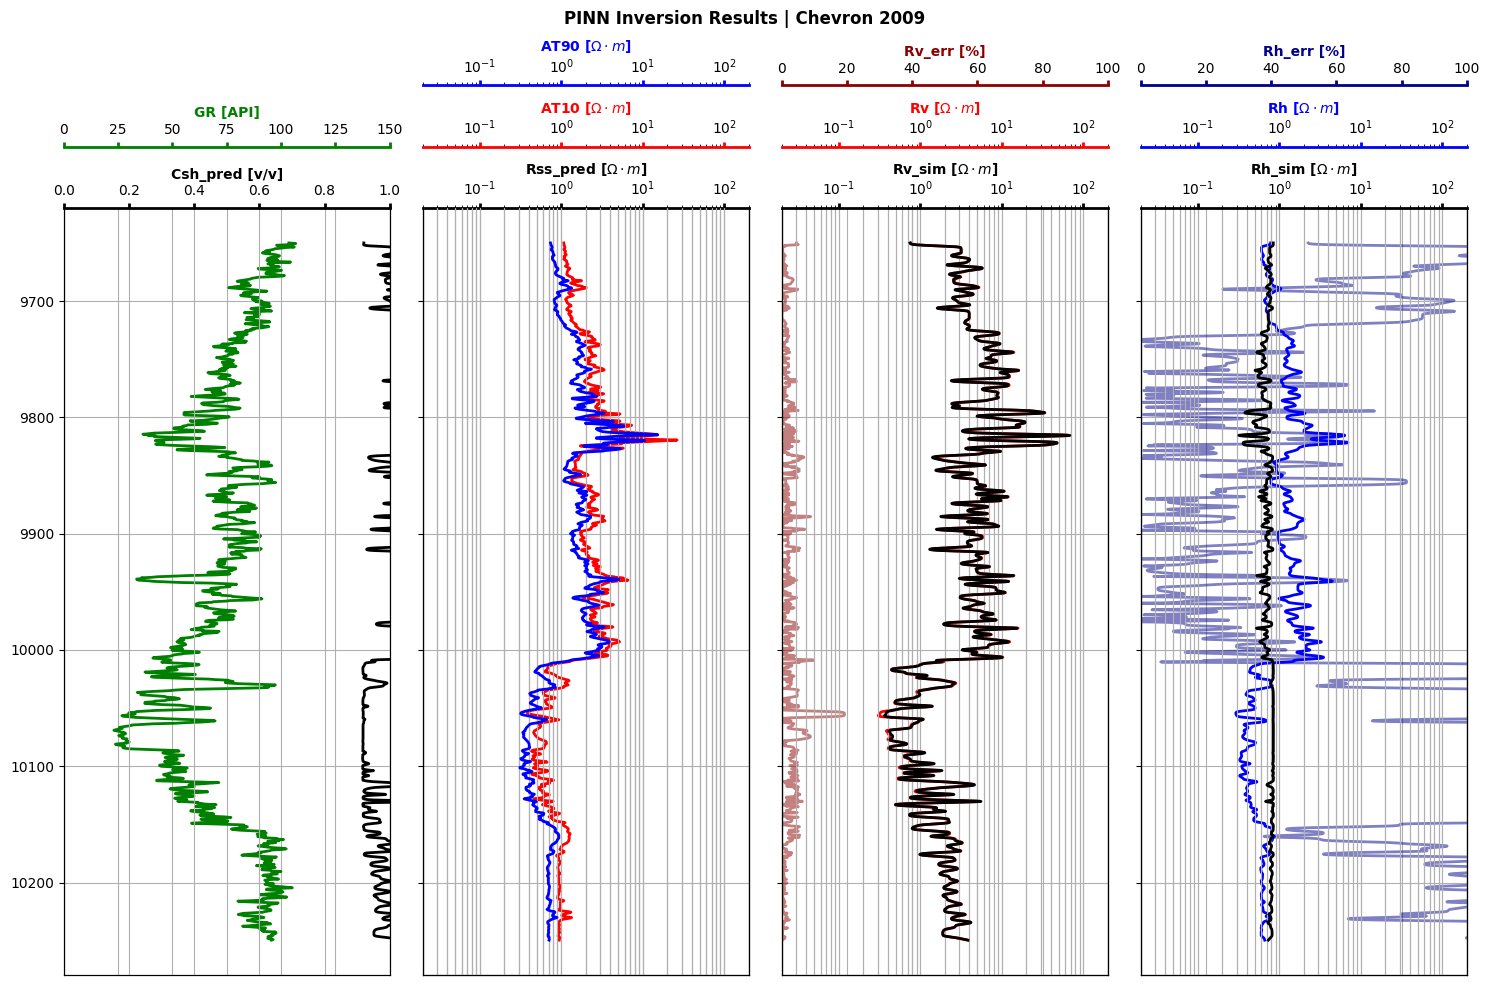

In [656]:
y = model(inputs).detach().numpy()
csh_pred, rss_pred = y[:,0], y[:,1]

Rv_sim = (csh_pred*Rvsh + (1-csh_pred)*rss_pred)
Rh_sim = (csh_pred/Rhsh + (1-csh_pred)/rss_pred)
Rv_err = np.abs((Rv_sim - case1['Rv'].values)/case1['Rv'].values) * 100
Rh_err = np.abs((Rh_sim - case1['Rh'].values)/case1['Rh'].values) * 100

sol = pd.DataFrame({'Csh_pred':csh_pred, 'Rss_pred':rss_pred,
                    'Rv_sim':Rv_sim, 'Rh_sim':1/Rh_sim,
                    'Rv_err':Rv_err, 'Rh_err':Rh_err}, index=case1.index)

results = pd.concat([case1, sol], axis=1)
plot_pinn_results(results, subtitle='Chevron 2009')

***
# END
***